# BiologicalConnectivity

Implement biological clustering quality measurement

Uses previously collected common pathway data from BioCyC for Arabidopsis

Davies Bouldin index gives us a 'structural' measure of how well the data has been clustered, but we also need a measurement of how weel the data has been biologically clustered

See milone_improving_2014 page 5 for a definition of a measure of biological connectivity

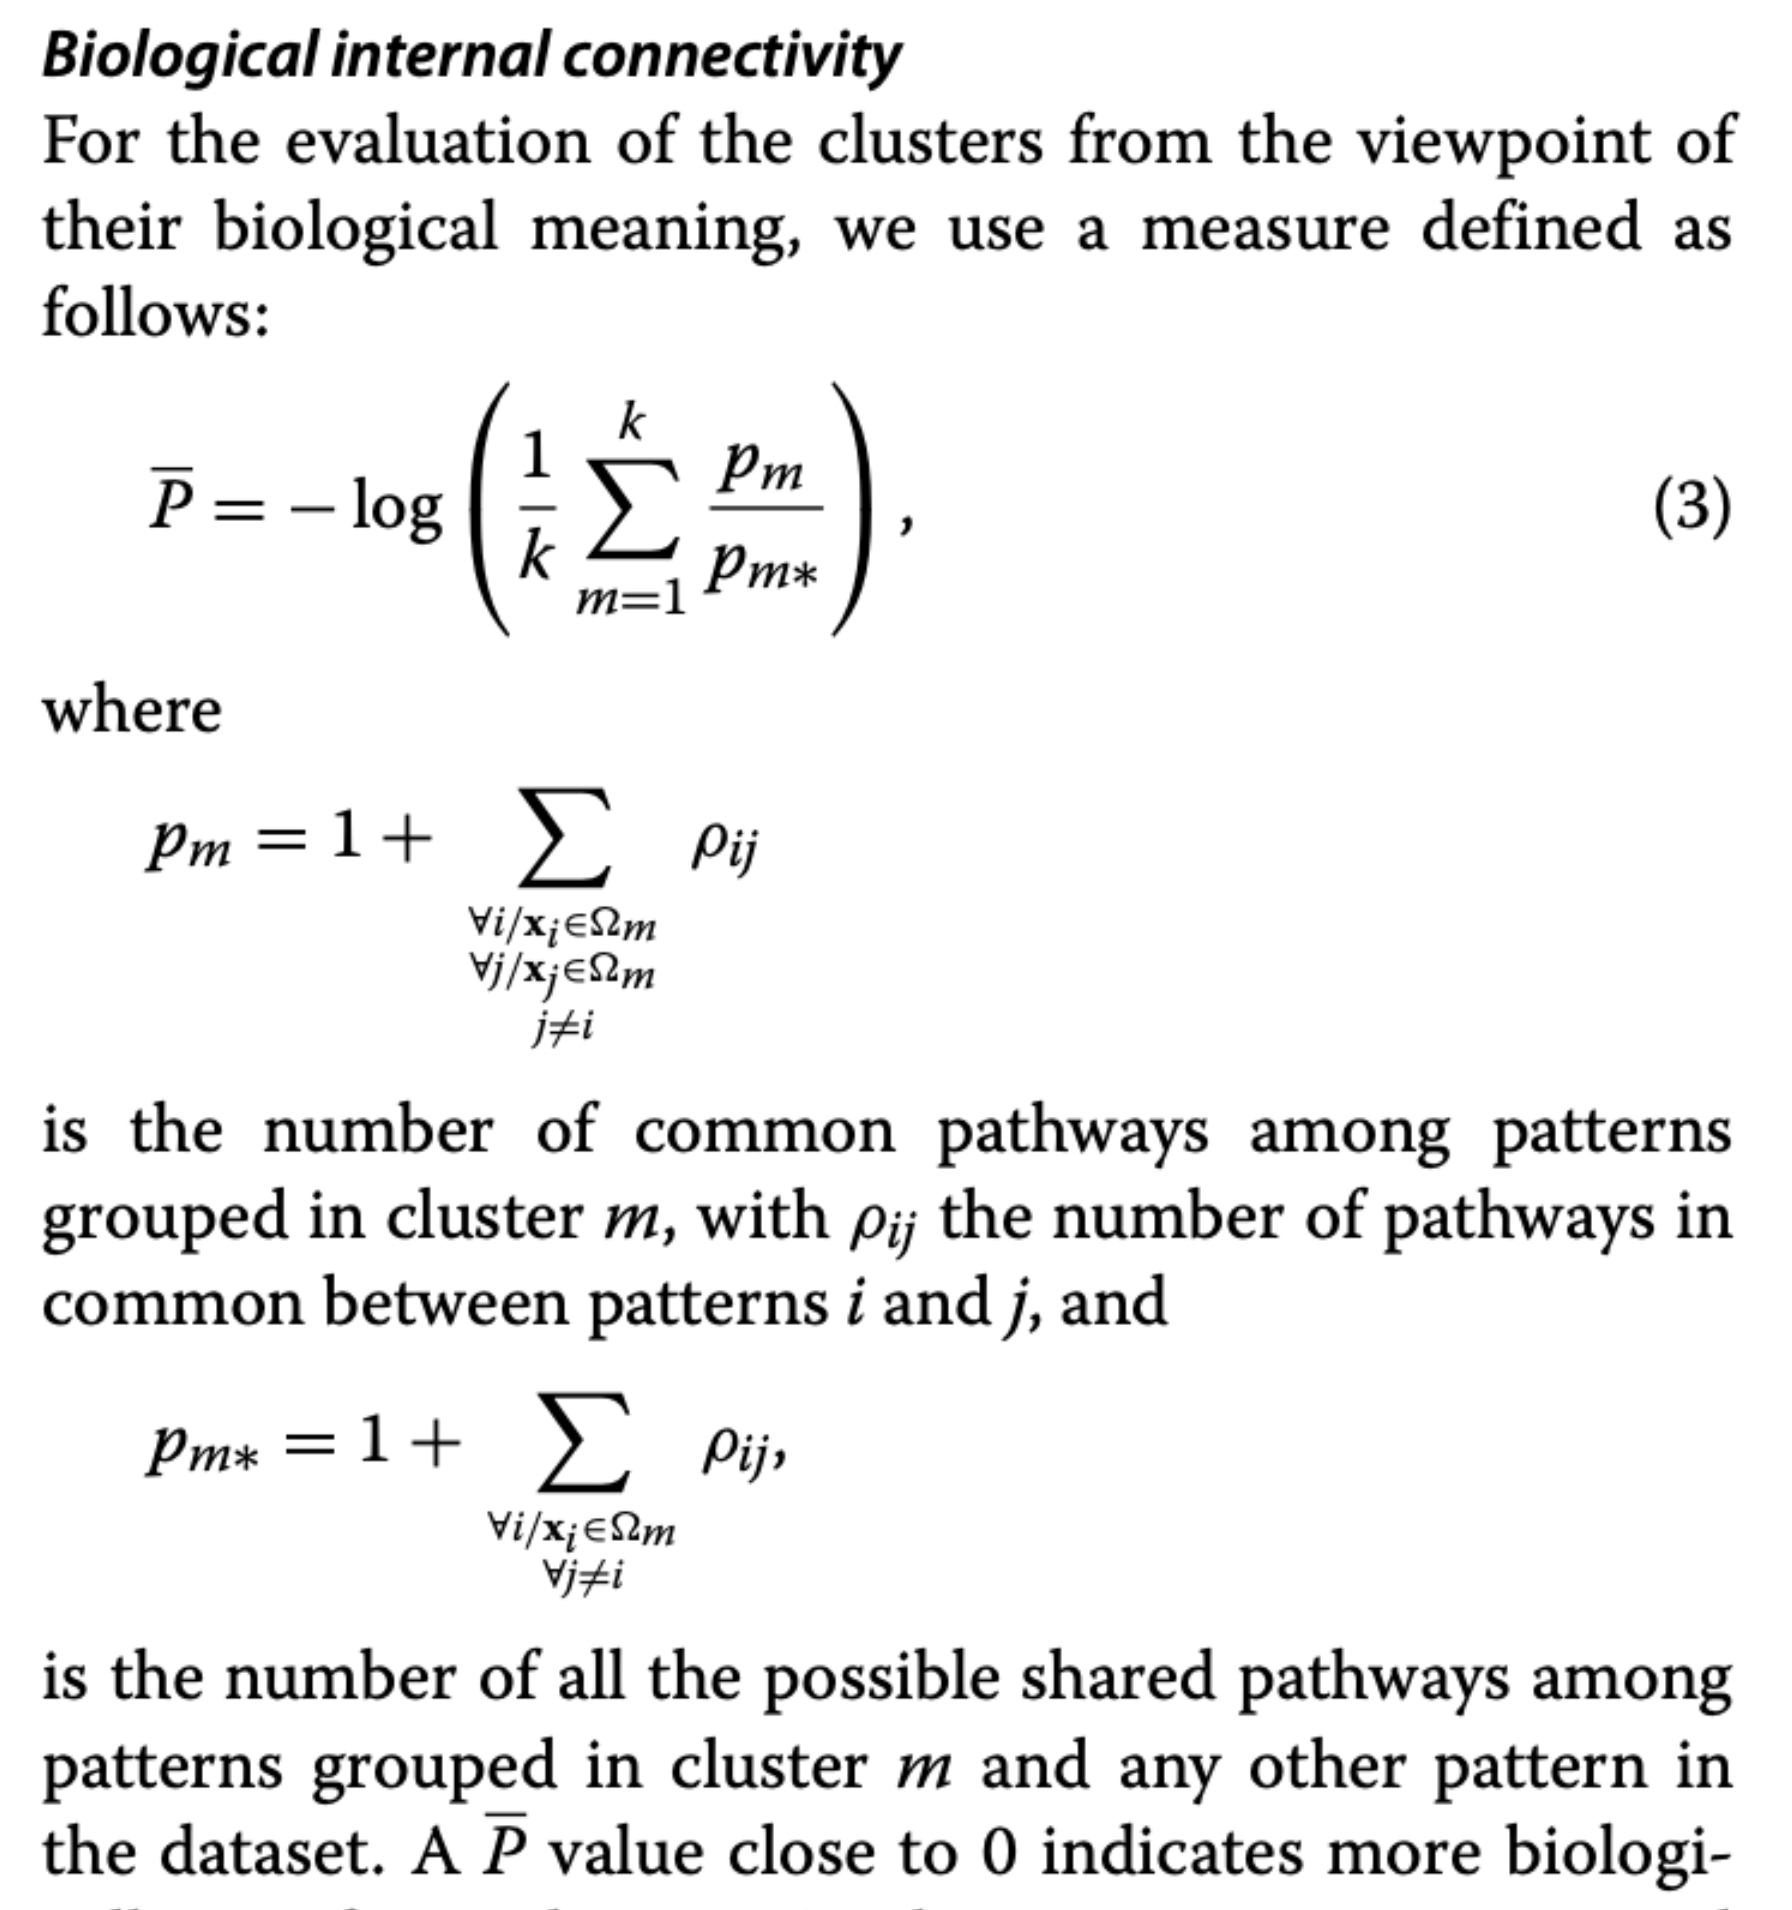

Lets do it for K-means with K=3

Lets do it for SOM with all clusters (including clusters with just one member) ...

Read in original data just to get a list of metabolites

In [1]:
import pandas as pd

ara_data_pd = pd.read_csv("./Data/Arabidopsis-T87-timeseries-NaCl-by-metabolite-BioCyc-Master.csv", skiprows=1, header=None)
metabolites = ara_data_pd[0] # Save metabolite names for later
print(metabolites)
ara_data_pd = ara_data_pd.drop(ara_data_pd.columns[[1]], axis=1) # Delete all metabolite names so just raw data
print(ara_data_pd.head(5))

0             PYRUVATE
1              LACTATE
2        ETHANOL-AMINE
3             GLYCEROL
4                  SUC
5            GLYCERATE
6                  FUM
7           CADAVERINE
8                  MAL
9     4-AMINO-BUTYRATE
10                 CYS
11     2-KETOGLUTARATE
12       CIS-ACONITATE
13          PUTRESCINE
14           SHIKIMATE
15                 CIT
16                 FRU
17             GLUCOSE
18                 LYS
19                 TYR
20           GLUCONATE
21           CPD0-1083
22               URATE
23             SUCROSE
24           TREHALOSE
25         L-ASPARTATE
26                 ASN
27                 SER
28                 GLY
29     L-ALPHA-ALANINE
30                 GLT
31                 GLN
32                 THR
33                 PRO
34                 VAL
35                 TRP
36                 ILE
37                 LEU
38                 PHE
39             FORMATE
40             FOLATES
Name: 0, dtype: object
               0     2     3     4

In [3]:
# Firat group are black/dark grey - represent strongest similarities
cluster_0 = ['TRP', 'TYR', 'LYS', 'PHE', 'ETHANOL-AMINE', 'CIT', 'LEU']
cluster_1 = ['CYS', 'ILE', 'URATE']
cluster_2 = ['FORMATE', 'GLYCERATE', '2-KETOGLUTARATE']
cluster_3 = ['CIS-ACONITATE', 'GLYCEROL']
cluster_4 = ['PYRUVATE', 'SUCROSE', 'LACTATE']

# Second group are mid/light gray - reduced strength of similariries
cluster_5 = ['VAL', 'PUTRESCINE', 'SER', 'GLN', 'GLT', 'FRU', 'SUC', 'SHIKIMATE', 'FUM']
cluster_6 = ['FOLATES', 'THR', 'PRO', 'TREHALOSE', 'CADAVERINE']
cluster_7 = ['GLUCOSE', 'GLUCONATE']

# Third group of singletons - not convinced these should be treated as clusters
cluster_8 = ['CPD0-1083']
cluster_9 = ['GLY']
cluster_10 = ['ASN']
cluster_11 = ['MAL']
cluster_12 = ['L-ASPARTATE']
cluster_13 = ['4-AMINO-BUTYRATE']
cluster_14 = ['L-ALPHA-ALANINE']

clusters = []

for metab in (range(0, len(metabolites))):
    if metabolites[metab] in cluster_0:
        clusters.append(0)
    if metabolites[metab] in cluster_1:
        clusters.append(1)
    if metabolites[metab] in cluster_2:
        clusters.append(2)
    if metabolites[metab] in cluster_3:
        clusters.append(3)
    if metabolites[metab] in cluster_4:
        clusters.append(4)
    if metabolites[metab] in cluster_5:
        clusters.append(5)
    if metabolites[metab] in cluster_6:
        clusters.append(6)
    if metabolites[metab] in cluster_7:
        clusters.append(7)
    if metabolites[metab] in cluster_8:
        clusters.append(8)
    if metabolites[metab] in cluster_9:
        clusters.append(9)
    if metabolites[metab] in cluster_10:
        clusters.append(10)
    if metabolites[metab] in cluster_11:
        clusters.append(11)
    if metabolites[metab] in cluster_12:
        clusters.append(12)
    if metabolites[metab] in cluster_13:
        clusters.append(13)
    if metabolites[metab] in cluster_14:
        clusters.append(14)

print(clusters)
print(len(clusters))

[4, 4, 0, 3, 5, 2, 5, 6, 11, 13, 1, 2, 3, 5, 5, 0, 5, 7, 0, 0, 7, 8, 1, 4, 6, 12, 10, 5, 9, 14, 5, 5, 6, 6, 5, 0, 1, 0, 0, 2, 6]
41


In [4]:
# Add cluster numbers to data
ara_data_pd['cluster'] = clusters
print(ara_data_pd.head(5))

               0     2     3     4     5     6     7     8      9  cluster
0       PYRUVATE  1.19  1.32  0.86  0.68  0.54  1.84  3.23   3.63        4
1        LACTATE  0.87  1.26  0.98  0.67  0.53  4.94  3.67  12.75        4
2  ETHANOL-AMINE  1.31  1.45  1.18  1.22  0.52  0.59  0.31   0.26        0
3       GLYCEROL  1.61  0.72  0.68  1.91  1.42  3.30  0.90   1.40        3
4            SUC  0.75  1.08  0.80  0.55  0.39  0.21  0.87   1.62        5


In [6]:
# Set value of K
k = 15

In [7]:
import math
import numpy as np

metab_list = list(metabolites)
print(metab_list)

# Create array of empty lists
cluster_metabolites = np.empty(k, dtype=object)
for i in range(cluster_metabolites.shape[0]):
    cluster_metabolites[i] = []

# Populate each list with metabolites in that cluster
for row in range(0, ara_data_pd.shape[0]):
    clust = ara_data_pd.iloc[row]['cluster']
    cluster_metabolites[clust].append(ara_data_pd.iloc[row][0])
for i in range(cluster_metabolites.shape[0]):
    print(i, cluster_metabolites[i])

# Read in common pathway date file
data_df = pd.read_csv("./Data/Arabidopsis-T87-timeseries-NaCl-by-metabolite-BioCyc-Master-Common-Pathways.csv")
print(data_df.head(5))

# Calculate intermediates
bio_con_df = pd.DataFrame(columns=['cluster', 'pm', 'pmstar'])

for clust in range(0, k):
    print("Cluster = ", clust)
    metab_in_cluster = []
    metab_out_cluster = []
    for metabolite in metabolites:
        if (metabolite in cluster_metabolites[clust]):
            metab_in_cluster.append(metabolite)
        else:
            metab_out_cluster.append(metabolite)
    print("In length = ", len(metab_in_cluster))
    print("In cluster = ", metab_in_cluster)
    print("Out length = ", len(metab_out_cluster))
    print("Out cluster = ", metab_out_cluster)

    # Calculate per cluster terms
    
    # Start with intra-cluster term
    pm = 0
    for x in metab_in_cluster:
        for y in metab_in_cluster:
            if (x == y):
                continue
            metab_x = metab_list.index(x)
            metab_y = metab_list.index(y)
            pm = pm + data_df.iloc[metab_x, metab_y+1]
    #pm = pm + 1

    # Next inter-cluster term
    pmstar = 0
    for x in metab_in_cluster:
        for y in metab_out_cluster:
            if (x == y):
                continue
            metab_x = metab_list.index(x)
            metab_y = metab_list.index(y)
            pmstar = pmstar + data_df.iloc[metab_x, metab_y+1]
    #pmstar = pmstar + 1
    
    print("Cluster = ", clust, "pm = ", pm, "pmstar = ", pmstar)

    new_row = {'cluster':clust, 'pm':pm, 'pmstar':pmstar}
    bio_con_df = bio_con_df.append(new_row, ignore_index=True)

print(bio_con_df)

# Finally calculate pbar
sum = 0
for clust in range(0, k):
    if (bio_con_df['pmstar'][clust] > 0):
        sum = sum + (bio_con_df['pm'][clust] / bio_con_df['pmstar'][clust])
print(sum)

#pbar = -math.log((1.0/k)*sum, 10)
pbar= (1.0/k)*sum
print("pbar = ", pbar)

['PYRUVATE', 'LACTATE', 'ETHANOL-AMINE', 'GLYCEROL', 'SUC', 'GLYCERATE', 'FUM', 'CADAVERINE', 'MAL', '4-AMINO-BUTYRATE', 'CYS', '2-KETOGLUTARATE', 'CIS-ACONITATE', 'PUTRESCINE', 'SHIKIMATE', 'CIT', 'FRU', 'GLUCOSE', 'LYS', 'TYR', 'GLUCONATE', 'CPD0-1083', 'URATE', 'SUCROSE', 'TREHALOSE', 'L-ASPARTATE', 'ASN', 'SER', 'GLY', 'L-ALPHA-ALANINE', 'GLT', 'GLN', 'THR', 'PRO', 'VAL', 'TRP', 'ILE', 'LEU', 'PHE', 'FORMATE', 'FOLATES']
0 ['ETHANOL-AMINE', 'CIT', 'LYS', 'TYR', 'TRP', 'LEU', 'PHE']
1 ['CYS', 'URATE', 'ILE']
2 ['GLYCERATE', '2-KETOGLUTARATE', 'FORMATE']
3 ['GLYCEROL', 'CIS-ACONITATE']
4 ['PYRUVATE', 'LACTATE', 'SUCROSE']
5 ['SUC', 'FUM', 'PUTRESCINE', 'SHIKIMATE', 'FRU', 'SER', 'GLT', 'GLN', 'VAL']
6 ['CADAVERINE', 'TREHALOSE', 'THR', 'PRO', 'FOLATES']
7 ['GLUCOSE', 'GLUCONATE']
8 ['CPD0-1083']
9 ['GLY']
10 ['ASN']
11 ['MAL']
12 ['L-ASPARTATE']
13 ['4-AMINO-BUTYRATE']
14 ['L-ALPHA-ALANINE']
      Unnamed: 0  PYRUVATE  LACTATE  ETHANOL-AMINE  GLYCEROL  SUC  GLYCERATE  \
0       PYRUV

/var/folders/s5/5rt4m34s5b9gmg32fzqdhqyc0000gn/T/ipykernel_29591/3832936253.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bio_con_df = bio_con_df.append(new_row, ignore_index=True)
/var/folders/s5/5rt4m34s5b9gmg32fzqdhqyc0000gn/T/ipykernel_29591/3832936253.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bio_con_df = bio_con_df.append(new_row, ignore_index=True)
/var/folders/s5/5rt4m34s5b9gmg32fzqdhqyc0000gn/T/ipykernel_29591/3832936253.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bio_con_df = bio_con_df.append(new_row, ignore_index=True)
/var/folders/s5/5rt4m34s5b9gmg32fzqdhqyc0000gn/T/ipykernel_29591/3832936253.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

OLD STUFF ...

Set k to equal number of clusters from previous K-means

In [ ]:
k = 5

In [ ]:
print(metabolites)

In [2]:
print(arr_data_pd)

NameError: name 'arr_data_pd' is not defined

In [ ]:
print(data_df.head(5))
#print(type(metabolites))
metab_list = metabolites.tolist()
print(metab_list)
x=metab_list.index('SUC')
y=metab_list.index('PYRUVATE')
print(type(x), type(y))
print(x, y)
print(data_df.iloc[4, 1])

In [1]:
import math
import numpy as np

# Create array of empty lists
cluster_metabolites = np.empty(k, dtype=object)
for i in range(cluster_metabolites.shape[0]):
    cluster_metabolites[i] = []

# Populate each list with metabolites in that cluster
for row in range(0, arr_data_pd.shape[0]):
    clust = arr_data_pd.iloc[row]['cluster']
    cluster_metabolites[clust].append(arr_data_pd.iloc[row]['metabolite'])
for i in range(cluster_metabolites.shape[0]):
    print(i, cluster_metabolites[i])

# Read in common pathway date file
data_df = pd.read_csv("./Data/Arabidopsis-T87-timeseries-NaCl-by-metabolite-BioCyc-Master-Common-Pathways.csv")
print(data_df.head(5))

# Calculate intermediates
bio_con_df = pd.DataFrame(columns=['cluster', 'pm', 'pmstar'])

for clust in range(0, k):
    print("Cluster = ", clust)
    metab_in_cluster = []
    metab_out_cluster = []
    for metabolite in metabolites:
        if (metabolite in cluster_metabolites[clust]):
            metab_in_cluster.append(metabolite)
        else:
            metab_out_cluster.append(metabolite)
    print("In length = ", len(metab_in_cluster))
    print("In cluster = ", metab_in_cluster)
    print("Out length = ", len(metab_out_cluster))
    print("Out cluster = ", metab_out_cluster)
    pm = 0
    pmstar = 0
    for x in metab_in_cluster:
        for y in metab_in_cluster:
            if (x == y):
                continue
            metab_x = metab_list.index(x)
            metab_y = metab_list.index(y)
            pm = pm + data_df.iloc[metab_x, metab_y+1]
            #print(x, y, metab_x, metab_y, data_df.iloc[metab_x, metab_y+1])
            #print(data_df.iloc[4, 1])
            #print("x = ", x, "y = ", y, data_df[x][y])
            #print(data_df[x], data_df[y])
            #pm = pm + 1
            #print("x = ", x, "y = ", y, "pm = ", pm)
            #print(x, y , pm)
    
    for x in metab_in_cluster:
        for y in metab_out_cluster:
            metab_x = metab_list.index(x)
            metab_y = metab_list.index(y)
            pmstar = pmstar + data_df.iloc[metab_x, metab_y+1]
    
    #print("Cluster = ", clust, "pm = ", pm, "pmstar = ", pmstar)

    new_row = {'cluster':clust, 'pm':pm, 'pmstar':pmstar}
    bio_con_df = bio_con_df.append(new_row, ignore_index=True)

print(bio_con_df)
#print(bio_con_df['pmstar'][2])

#print(bio_con_df['pm',1)

sum = 0
for clust in range(0, k):
    if (bio_con_df['pmstar'][clust] > 0):
        sum = sum + (bio_con_df['pm'][clust] / bio_con_df['pmstar'][clust])
print(sum)

result = -math.log((1.0/k)*sum, 10)
print(result)

NameError: name 'np' is not defined

In [ ]:
bio_con_df = pd.DataFrame(columns=['Cluster', 'pm', 'pmstar'])
for cluster in range (0, k):
    print("cluster ", cluster)
    for col_meta in range(0, len(cluster_metabolites[clust])):
        print(cluster_metabolites[clust])

ADD A GRAPH THAT SHOWS SILHOUTTE VS BICON FOR A RANGE OF VALUES OF K

Plot K=2 to 10 show silhoutte vs biocon ...